In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/planet-understanding-the-amazon-from-space/Kaggle-planet-train-tif.torrent
/kaggle/input/planet-understanding-the-amazon-from-space/Kaggle-planet-test-tif.torrent
/kaggle/input/planet-understanding-the-amazon-from-space/test_v2_file_mapping.csv/test_v2_file_mapping.csv
/kaggle/input/planet-understanding-the-amazon-from-space/train_v2.csv/train_v2.csv
/kaggle/input/planet-understanding-the-amazon-from-space/sample_submission_v2.csv/sample_submission_v2.csv


In [26]:
import numpy as np
import seaborn as sns
import gc 
import matplotlib.pyplot as plt
import cv2 
import tensorflow as tf
from tensorflow import keras
#from tqdm import tqdm 
from matplotlib.image import imread
from sklearn.model_selection import train_test_split
from keras import optimizers
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.callbacks import EarlyStopping 
from keras.preprocessing.image import ImageDataGenerator

import warnings
# filter warnings
warnings.filterwarnings('ignore')

In [15]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [16]:
import cv2 
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split



In [5]:
# loading the files

train_df= pd.read_csv('/kaggle/input/planet-understanding-the-amazon-from-space/train_v2.csv/train_v2.csv')
test_df= pd.read_csv('/kaggle/input/planet-understanding-the-amazon-from-space/test_v2_file_mapping.csv/test_v2_file_mapping.csv')
train_images = '/kaggle/input/planet-understanding-the-amazon-from-space/Kaggle-planet-train-tif.torrent'
test_images = '/kaggle/input/planet-understanding-the-amazon-from-space/Kaggle-planet-test-tif.torrent'
train_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


## Exploratory Analysis

In [6]:
# checking for duplicates and null values
train_df.duplicated().sum()

0

In [7]:
train_df.isna().sum()

image_name    0
tags          0
dtype: int64

In [9]:
# checking the count of each tag
train_df['tags'].value_counts()

tags
clear primary                                               13636
partly_cloudy primary                                        3630
cloudy                                                       2089
clear primary water                                          1850
agriculture clear primary road                               1680
                                                            ...  
agriculture clear cultivation cultivation road                  1
artisinal_mine bare_ground partly_cloudy primary road           1
agriculture clear conventional_mine primary road                1
clear conventional_mine habitation road                         1
agriculture partly_cloudy primary road conventional_mine        1
Name: count, Length: 449, dtype: int64

In [13]:
# checking the number of unique tags
train_df.tags.nunique()

449

primary              37513
clear                28431
agriculture          12315
road                  8071
water                 7411
partly_cloudy         7261
cultivation           4547
habitation            3660
haze                  2697
cloudy                2089
bare_ground            862
selective_logging      340
artisinal_mine         339
blooming               332
slash_burn             209
blow_down              101
conventional_mine      100
Name: count, dtype: int64

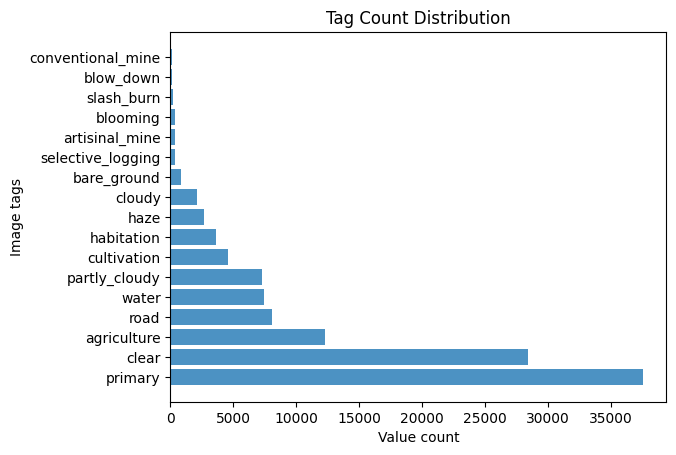

In [35]:
# checking the distribution of tags
tag_list= train_df.tags.apply(lambda x: x.split(' '))
tag_list = [tag for name in tags for tag in name]
tag_count = pd.Series(tag_list).value_counts()
display(tag_count)

# plotting the distribution
plt.barh(tag_count.index, tag_count.values , alpha=0.8)
plt.ylabel('Image tags')
plt.xlabel('Value count')
plt.title('Tag Count Distribution')
plt.show();

## Preprocessing

In [37]:
labels = set()
def splitting_tags(tag_list):
    '''
    Takes in tags column, splits the tags and store as a set
    '''
    [labels.add(tag) for tag in tag_list.split()]
    
# Create a copy of `train_df`
train_df1 = train_df.copy()
train_df1['tags'].apply(splitting_tags)
labels = list(labels)
print(labels)


['cloudy', 'blooming', 'habitation', 'agriculture', 'haze', 'cultivation', 'road', 'slash_burn', 'artisinal_mine', 'water', 'partly_cloudy', 'blow_down', 'selective_logging', 'bare_ground', 'primary', 'clear', 'conventional_mine']


In [38]:
##One hot encoding is performed on the labels in train classes 
for tag in labels:
    train_df1[tag] = train_df1['tags'].apply(lambda x: 1 if tag in x.split() else 0)
    
## adding .jpg extension to the column image_name so as to have same name format as the image files
train_df1['image_name'] = train_df1['image_name'].apply(lambda x: '{}.jpg'.format(x))
train_df1.head()

,image_name,tags,cloudy,blooming,habitation,agriculture,haze,cultivation,road,slash_burn,artisinal_mine,water,partly_cloudy,blow_down,selective_logging,bare_ground,primary,clear,conventional_mine
0,train_0.jpg,haze primary,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
1,train_1.jpg,agriculture clear primary water,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,1,0
2,train_2.jpg,clear primary,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
3,train_3.jpg,clear primary,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
4,train_4.jpg,agriculture clear habitation primary road,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,1,0


In [39]:
# Define the columns
columns = list(train_df1.columns[2:])
columns

['cloudy',
 'blooming',
 'habitation',
 'agriculture',
 'haze',
 'cultivation',
 'road',
 'slash_burn',
 'artisinal_mine',
 'water',
 'partly_cloudy',
 'blow_down',
 'selective_logging',
 'bare_ground',
 'primary',
 'clear',
 'conventional_mine']

In [40]:
gc.collect()

11576

In [41]:
# Initializing imagedatagenerator with a validation split of 0.2
train_datagen = ImageDataGenerator(rescale = 1./255., validation_split = 0.2)

# Generating train data generator 
train_generator = train_datagen.flow_from_dataframe(dataframe=train_df1,
                                                    directory =train_images, 
                                                    x_col='image_name', y_col=columns, subset='training', 
                                                    batch_size=32,seed=42, shuffle=True, 
                                                    class_mode='raw', target_size=(128,128))

#generating validation data which is expected to be 20% of the train dataset since validation split is 0.2
val_generator = train_datagen.flow_from_dataframe(dataframe=train_df1,
                                                  directory =train_images, 
                                                  x_col='image_name', y_col=columns, subset='validation', 
                                                  batch_size=32,seed=42, shuffle=True, 
                                                  class_mode='raw', target_size=(128,128))

Found 0 validated image filenames.
Found 0 validated image filenames.


In [42]:
#setting up step size for training and validation image data
step_train_size = int(np.ceil(train_generator.samples / train_generator.batch_size))
step_val_size = int(np.ceil(val_generator.samples / val_generator.batch_size))

In [43]:
gc.collect()

0

## Modelling

In [44]:
# Define the model
def cnn_model():
    model = Sequential()

    # Convolution layers
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(128, 128, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Flatten layer
    model.add(Flatten())

    # Fully connected layers
    model.add(Dense(units=512, activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(units=17, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer=Adam(lr=0.001), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    
    return model

In [45]:
#initialize the model
model = cnn_model()

# Preview the model architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 32, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 16, 16, 128)       0

In [46]:
# define callbacks
earlystop = EarlyStopping(monitor='val_accuracy', 
                          patience=2, verbose=1, 
                          mode='max', 
                          restore_best_weights=True)

In [47]:
gc.collect()

1356

In [51]:
# Fit the model 
history = model.fit(x = train_generator, 
                    steps_per_epoch = step_train_size, 
                    validation_data = val_generator,
                    validation_steps = step_val_size,
                    epochs = 20, 
                    callbacks = [earlystop])

ValueError: Asked to retrieve element 0, but the Sequence has length 0

In [49]:
gc.collect()

2169

NameError: name 'history' is not defined

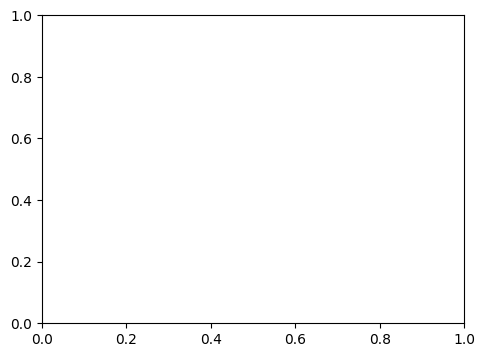

In [50]:
# Plot the training and validation accuracy and loss curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper left')

plt.show()

In [52]:
model1 = cnn.model()

NameError: name 'cnn' is not defined

In [54]:
sample_submission = pd.read_csv('/kaggle/input/planet-understanding-the-amazon-from-space/sample_submission_v2.csv/sample_submission_v2.csv')
sample_submission.head()

,image_name,tags
0,test_0,primary clear agriculture road water
1,test_1,primary clear agriculture road water
2,test_2,primary clear agriculture road water
3,test_3,primary clear agriculture road water
4,test_4,primary clear agriculture road water


In [ ]:
sample_submission1['image_name'] = sample_submission1['image_name'].apply(lambda x: '{}.jpg'.format(x))
sample_submission1.head()

In [57]:
#initialize imagedatagenerator for the test images and also rescaling
test_datagen = ImageDataGenerator(rescale = 1/255)

#creating a generator for the images found in the first test image files
test_gen = test_datagen.flow_from_dataframe(dataframe=test_df, 
                                            directory='/kaggle/input/planets-dataset/planet/planet/test-jpg/', 
                                            x_col="image_name", 
                                            y_col=None, 
                                            batch_size=32,
                                            seed=42,
                                            shuffle=False, 
                                            class_mode=None, 
                                            target_size=(128,128))

step_test_size1 = int(np.ceil(test_gen.samples/test_gen.batch_size))

KeyError: 'image_name'

In [58]:
# Get the filenames in the generator using the attribute .filenames
file_names = test_gen.filenames

# Convert the predicted values to a dataframe and join two labels together if prob(occurrance of the label) > 0.5 
pred_tags = pd.DataFrame(pred)
pred_tags = pred_tags.apply(lambda x: ' '.join(np.array(labels)[x > 0.5]), axis = 1)

#then the result should look like this 
result1 = pd.DataFrame({'image_name': file_names, 'tags': pred_tags})
result1.head()

NameError: name 'test_gen' is not defined